In [43]:
import numpy as np
import pandas as pd
import seaborn as sns

In [44]:
# Original file was not encoded in UTF-8
df=pd.read_csv('spam.csv',encoding='ISO-8859-1')    

## Work Flow
1. Data Cleaning
2. EDA
3. Text Preprocessing
4. Model Building
5. Evaluation
6. Improvement
7. Website
8. Deployment

# Step-1: Data Cleaning

In [45]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [46]:
# Transform spam values to 1 and not spam to 0 in target
from sklearn.preprocessing import LabelEncoder      
encoder=LabelEncoder()
df['target']=encoder.fit_transform(df['target'])

In [47]:
df=df.drop_duplicates(keep='first')

# Step-2: Exploratory Data Analysis

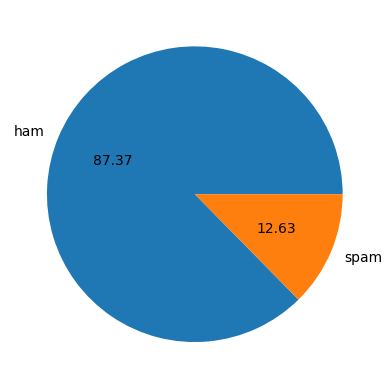

In [48]:
#df['target'].value_counts() = spam(653),ham(4516) -ie- imbalanced data
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct="%0.2f")  #pie chart with after decimal 2 values (0.2float) ie- autopercentage
plt.show()

In [49]:
# For splitting text into individual sentences
import nltk                   
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [50]:
df['num_characters']=df['text'].apply(len)                                  # stores char lengths 
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))       # no.of words or tokens
df['num_sentences']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))   # no.of sentences (comma separated)

In [51]:
#for ham
df[df['target']==0][['num_characters','num_words','num_sentences']].describe()
#for spam
df[df['target']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


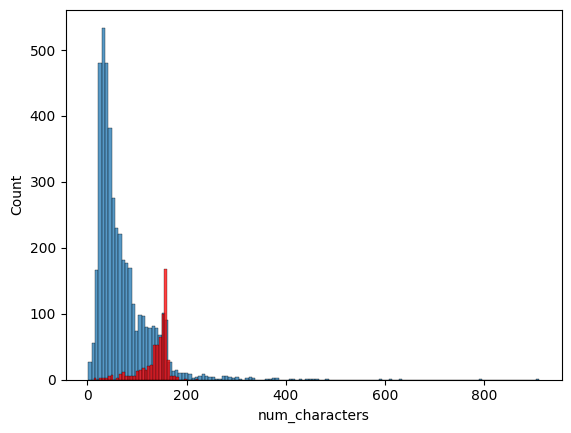

In [52]:
# Histogram Representation
import seaborn as sns
sns.histplot(df[df['target']==0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'],color='red')
plt.show()

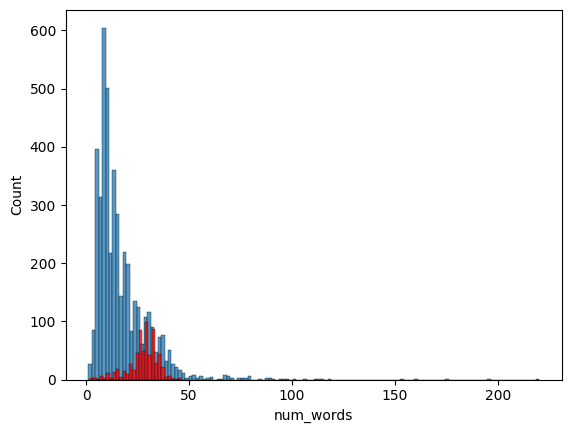

In [53]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'],color='red')
plt.show()

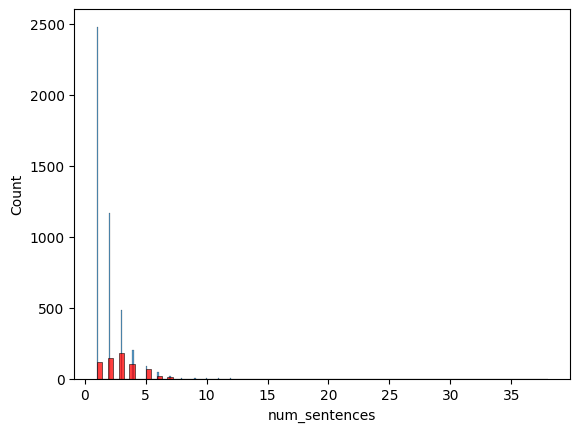

In [54]:
sns.histplot(df[df['target']==0]['num_sentences'])
sns.histplot(df[df['target']==1]['num_sentences'],color='red')
plt.show()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


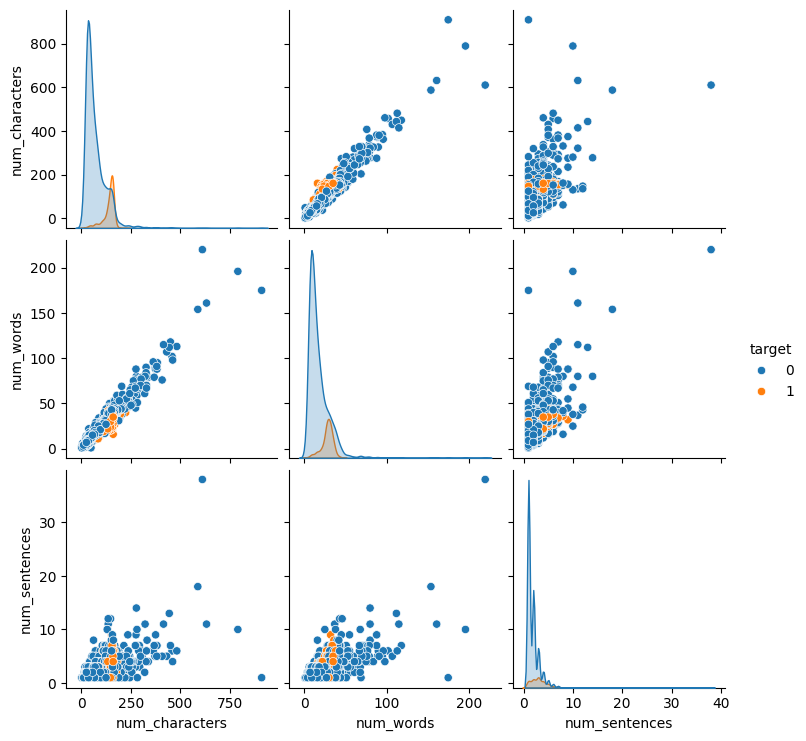

In [55]:
# To see outliers
sns.pairplot(df,hue='target') 
plt.show()

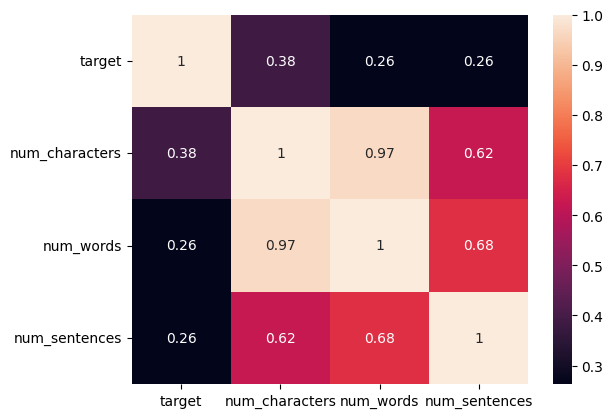

In [56]:
# To find correlations on a heatmap ,annotation will show values
# num_characters has the strongest corr() with target
sns.heatmap(df.corr(numeric_only=True),annot=True)        
plt.show()

# Step-3: Data Preprocessing
1) Lower Case 
2) Tokenization -- breaks into small words
3) Removing special chars
4) Removing stop words and punctuation
5) Stemming

In [57]:
def transform_text(text):
    # step-1
    text=text.lower()   
    # step-2
    text=nltk.word_tokenize(text)            
    # step-3 Only using alphanumeric terms
    y=[]                                     
    for i in text:
        if i.isalnum():
            y.append(i)
    # cloning
    text=y[:]                               
    y.clear()
    # step-4
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:         
            y.append(i)
    text=y[:]
    y.clear()
    # Step-5
    for i in text:
        y.append(ps.stem(i)) 
    # Conversion to string
    return " ".join(y)                      

In [58]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string 
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
df['transformed_text']=df['text'].apply(transform_text)

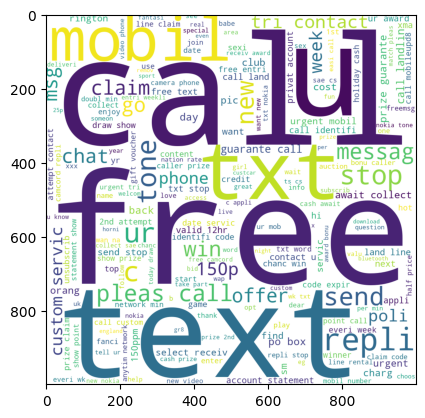

In [60]:
from wordcloud import WordCloud
wc=WordCloud(width=1000,height=1000,min_font_size=10,background_color='white')
spam_wc=wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

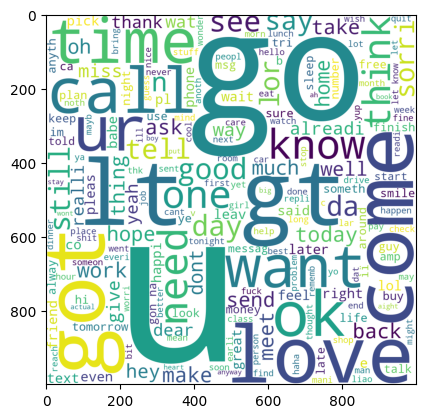

In [61]:
ham_wc=wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)

In [62]:
# Spam words 
spam_corpus=[]
for msg in df[df['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
#len(spam_corpus)   -- total words are 9939

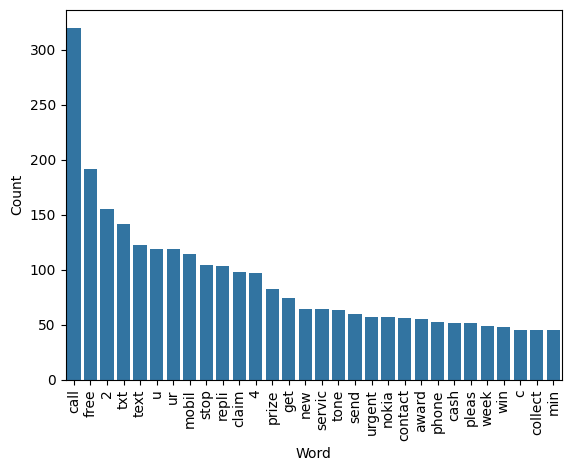

In [63]:
# Mapping
from collections import Counter
spam_df = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['Word', 'Count'])
sns.barplot(x='Word', y='Count', data=spam_df)
# Values on x axis were in horizontal shape
plt.xticks(rotation='vertical')                            
plt.show()

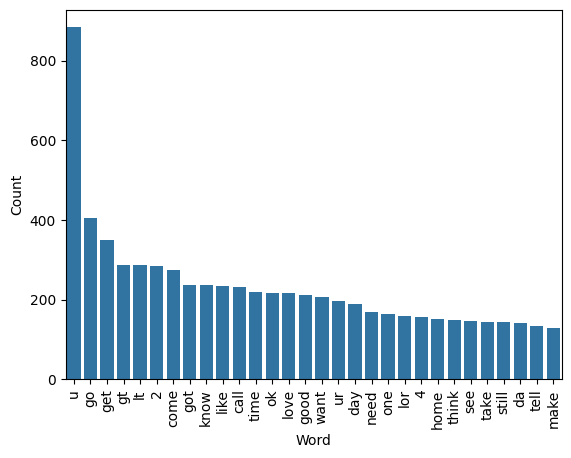

In [64]:
ham_corpus=[]
for msg in df[df['target']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
ham_df = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['Word', 'Count'])
sns.barplot(x='Word', y='Count', data=ham_df)
plt.xticks(rotation='vertical')                      
plt.show()

# Step-4: Model Building

In [65]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv=CountVectorizer()
tfidf=TfidfVectorizer(max_features=3000)
X=tfidf.fit_transform(df['transformed_text']).toarray()
#X=cv.fit_transform(df['transformed_text']).toarray()
# X.shape  -- 5169 SMS 6708 Messages  
y= df['target'].values                  # Using transformed text and target (spam or ham) to classify SMS

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.2,random_state=2)
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [67]:
gnb=GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

In [68]:
gnb.fit(X_train,y_train)
y_pred1=gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8907156673114119
[[3272  359]
 [  93  412]]
0.5343709468223087


In [69]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9320599613152805
[[3631    0]
 [ 281  224]]
1.0


In [70]:
bnb.fit(X_train,y_train)
y_pred3=bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9489845261121856
[[3626    5]
 [ 206  299]]
0.9835526315789473


In [71]:
# we used tfidf instead of cv (CountVec) --> and mnb gave the best precision_score

In [72]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))